<a href="https://colab.research.google.com/github/oxc3949/bioinformatics-project/blob/main/Morpho%26MLflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Morphometry analysis workflow in python, for R script please refer to [github](https://github.com/oxc3949/bioinformatics-project)

<Figure size 800x600 with 0 Axes>

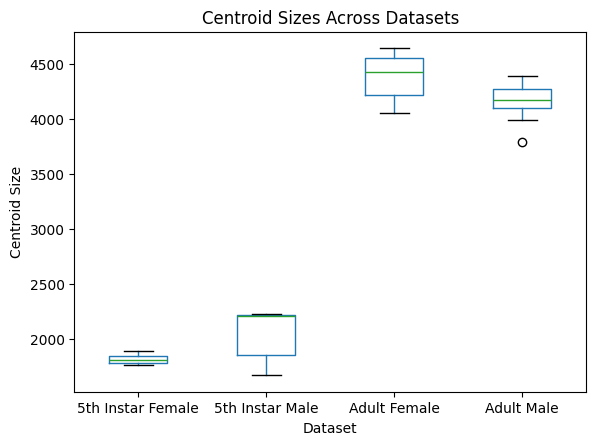

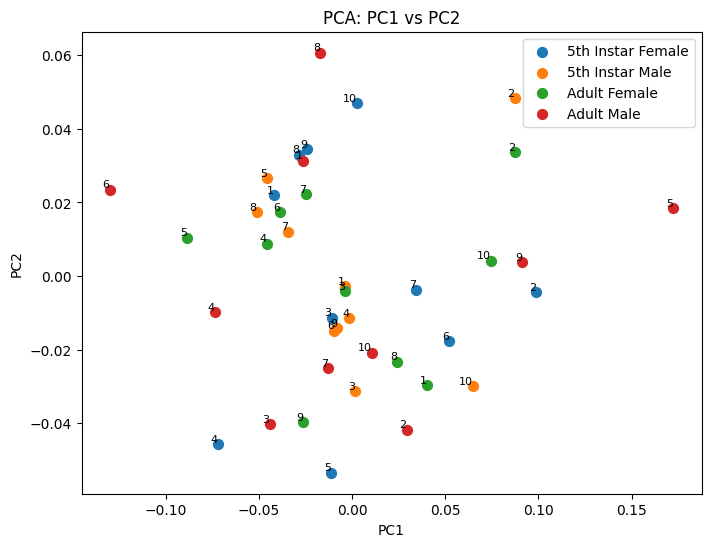

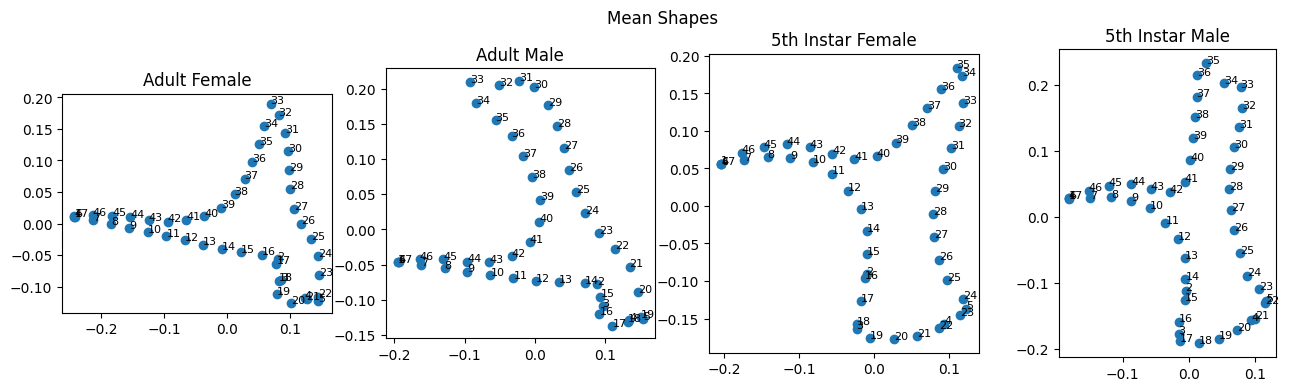

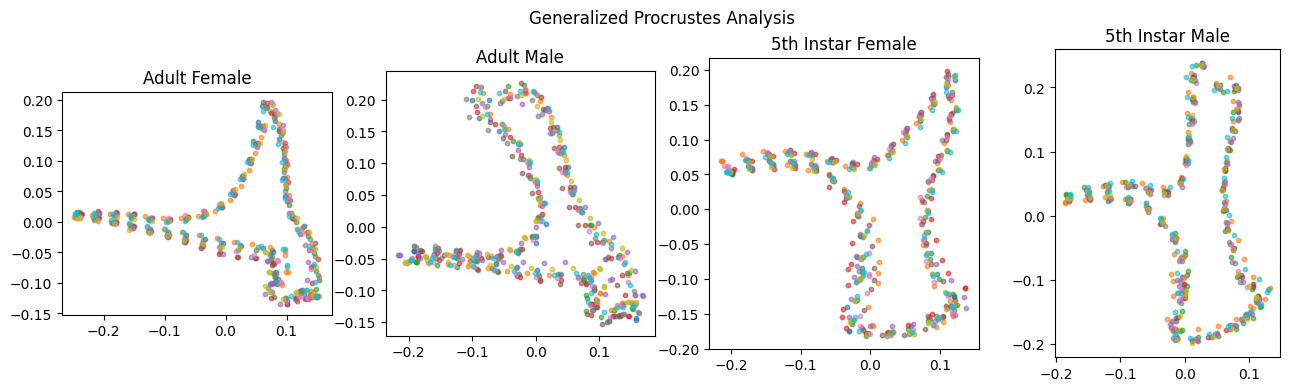

Procrustes ANOVA:
F = 345.524, p = 0.0000

Pairwise group comparisons:
           Group1          Group2           F    p
0   5fem_rand.tps  5masc_rand.TPS  170.589236  0.0
1   5fem_rand.tps   AFem_rand.TPS  305.974487  0.0
2   5fem_rand.tps  AMasc_rand.TPS  570.152289  0.0
3  5masc_rand.TPS   AFem_rand.TPS  339.335279  0.0
4  5masc_rand.TPS  AMasc_rand.TPS  345.579892  0.0
5   AFem_rand.TPS  AMasc_rand.TPS  243.259833  0.0


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from numpy.linalg import lstsq
import os

# ---------------------------
# Settings
# ---------------------------
tps_files = ["AFem_rand.TPS", "AMasc_rand.TPS", "5fem_rand.tps", "5masc_rand.TPS"]
custom_names = {
    "5fem_rand.tps": "5th Instar Female",
    "5masc_rand.TPS": "5th Instar Male",
    "AFem_rand.TPS": "Adult Female",
    "AMasc_rand.TPS": "Adult Male"
}
out_dir = "morpho_python_outputs"
os.makedirs(out_dir, exist_ok=True)
n_permutations = 999
np.random.seed(42)

# ---------------------------
# Read TPS file (fixed + semilandmarks)
# ---------------------------
def read_tps_semilandmarks(filename):
    specimens = []
    with open(filename, 'r') as f:
        lines = [l.strip() for l in f if l.strip() and not l.startswith('#')]
    i = 0
    while i < len(lines):
        if lines[i].startswith('LM='):
            n_fixed = int(lines[i].split('=')[1])
            i += 1
            fixed = []
            for _ in range(n_fixed):
                x, y = map(float, lines[i].split())
                fixed.append([x, y])
                i += 1
            semilandmarks = []
            while i < len(lines) and not lines[i].startswith('LM='):
                if lines[i].startswith('CURVE=') or lines[i].startswith('ID='):
                    i += 1
                    continue
                try:
                    x, y = map(float, lines[i].split())
                    semilandmarks.append([x, y])
                except:
                    pass
                i += 1
            specimen = np.array(fixed + semilandmarks)
            specimens.append(specimen)
        else:
            i += 1
    return np.stack(specimens, axis=2)

# ---------------------------
# GPA
# ---------------------------
def generalized_procrustes(coords, tol=1e-6, max_iter=100):
    k, dim, n = coords.shape
    X = coords.copy().astype(float)
    # Center
    for i in range(n):
        X[:, :, i] -= X[:, :, i].mean(axis=0)
    # Scale
    for i in range(n):
        cs = np.sqrt(np.sum(X[:, :, i]**2))
        X[:, :, i] /= cs
    mean_shape = X.mean(axis=2)
    prev_ss = np.inf
    for it in range(max_iter):
        for i in range(n):
            Y = X[:, :, i]
            A = mean_shape.T @ Y
            U, _, Vt = np.linalg.svd(A)
            R = U @ Vt
            X[:, :, i] = Y @ R.T
        new_mean = X.mean(axis=2)
        ss = np.sum((X - new_mean[:, :, None])**2)
        if abs(prev_ss - ss) < tol:
            mean_shape = new_mean
            break
        mean_shape = new_mean
        prev_ss = ss
    centroid_sizes = np.array([np.sqrt(np.sum((coords[:, :, i] - coords[:, :, i].mean(axis=0))**2))
                               for i in range(n)])
    return {'coords': X, 'mshape': mean_shape, 'Csize': centroid_sizes}

# ---------------------------
# Process all datasets
# ---------------------------
all_gpa = {}
all_centroid_sizes = {}
all_pca = {}
all_mean_shapes = {}

for file in tps_files:
    coords = read_tps_semilandmarks(file)
    gpa = generalized_procrustes(coords)
    all_gpa[file] = gpa
    all_centroid_sizes[file] = gpa['Csize']
    all_mean_shapes[file] = gpa['mshape']

    # PCA on original GPA coordinates
    k,d,n = gpa['coords'].shape
    X = gpa['coords'].reshape(k*d, n).T
    pca_model = PCA()
    scores = pca_model.fit_transform(X)
    all_pca[file] = {'pca': pca_model, 'scores': scores}

    # Pairwise distances
    dist_mat = squareform(pdist(X))
    df_dist = pd.DataFrame(dist_mat, index=[f"Specimen{i+1}" for i in range(n)],
                           columns=[f"Specimen{i+1}" for i in range(n)])
    df_dist.to_csv(os.path.join(out_dir, f"Distances_{os.path.splitext(file)[0]}.csv"))

# ---------------------------
# Centroid sizes boxplot
# ---------------------------
centroid_df = pd.concat([
    pd.DataFrame({
        'Specimen': np.arange(1, len(all_centroid_sizes[f]) + 1),
        'Size': all_centroid_sizes[f],
        'Dataset': f
    }) for f in tps_files
], ignore_index=True)
centroid_df['DatasetLabel'] = centroid_df['Dataset'].map(custom_names)

plt.figure(figsize=(8,6))
centroid_df.boxplot(column='Size', by='DatasetLabel', grid=False)
plt.title('Centroid Sizes Across Datasets')
plt.suptitle('')
plt.xlabel('Dataset')
plt.ylabel('Centroid Size')
plt.show()

# ---------------------------
# PCA plot
# ---------------------------
pca_frames = []
for f in tps_files:
    scores = all_pca[f]['scores']
    dfp = pd.DataFrame({
        'PC1': scores[:,0],
        'PC2': scores[:,1],
        'Dataset': f,
        'Specimen': np.arange(1, scores.shape[0]+1)
    })
    dfp['DatasetLabel'] = dfp['Dataset'].map(custom_names)
    pca_frames.append(dfp)
pca_scores_df = pd.concat(pca_frames, ignore_index=True)

plt.figure(figsize=(8,6))
for label, grp in pca_scores_df.groupby('DatasetLabel'):
    plt.scatter(grp['PC1'], grp['PC2'], label=label, s=50)
    for _, r in grp.iterrows():
        plt.text(r['PC1'], r['PC2'], str(int(r['Specimen'])), fontsize=8, va='bottom', ha='right')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: PC1 vs PC2')
plt.legend()
plt.show()

# ---------------------------
# Mean shapes faceted plot
# ---------------------------
mean_shapes_df = []
for f in tps_files:
    coords = all_mean_shapes[f]
    nland = coords.shape[0]
    dfm = pd.DataFrame({
        'X': coords[:,0],
        'Y': coords[:,1],
        'Landmark': np.arange(1, nland+1),
        'Dataset': f,
        'DatasetLabel': custom_names[f]
    })
    mean_shapes_df.append(dfm)
mean_shapes_df = pd.concat(mean_shapes_df, ignore_index=True)

unique_labels = mean_shapes_df['DatasetLabel'].unique()
ncols = len(unique_labels)
fig, axes = plt.subplots(1, ncols, figsize=(4*ncols,4))
if ncols==1: axes = [axes]

for ax, label in zip(axes, unique_labels):
    subset = mean_shapes_df[mean_shapes_df['DatasetLabel']==label]
    ax.scatter(subset['X'], subset['Y'])
    for _, r in subset.iterrows():
        ax.text(r['X'], r['Y'], str(int(r['Landmark'])), fontsize=8)
    ax.set_title(label)
    ax.set_aspect('equal')
plt.suptitle("Mean Shapes")
plt.show()

# ---------------------------
# GPA plot of all specimens (points only)
# ---------------------------
fig, axes = plt.subplots(1, ncols, figsize=(4*ncols,4))
if ncols == 1:
    axes = [axes]

for ax, f in zip(axes, tps_files):
    gpa_data = all_gpa[f]
    n_specimens = gpa_data['coords'].shape[2]

    for i in range(n_specimens):
        coords = gpa_data['coords'][:,:,i]
        # Plot landmarks as points only
        ax.scatter(coords[:,0], coords[:,1], alpha=0.6, s=10)

    ax.set_title(custom_names[f])
    ax.set_aspect('equal')
    # No flipping, no rotation

plt.suptitle("Generalized Procrustes Analysis")
plt.show()
import numpy as np
import pandas as pd
from itertools import combinations

# ---------------------------
# Helper functions
# ---------------------------

def procrustes_ss(coords, groups):
    """
    Compute sum-of-squares (SS) for group differences in Procrustes-aligned coordinates.

    coords: [landmarks, dim, specimens]
    groups: list/array of group labels per specimen
    """
    coords = np.array(coords)
    groups = np.array(groups)
    unique_groups = np.unique(groups)
    grand_mean = coords.mean(axis=2)

    # Total SS
    total_ss = np.sum((coords - grand_mean[:,:,None])**2)

    # Between-group SS
    ss_between = 0
    for g in unique_groups:
        idx = np.where(groups == g)[0]
        group_mean = coords[:,:,idx].mean(axis=2)
        ss_between += len(idx) * np.sum((group_mean - grand_mean)**2)

    # Within-group SS
    ss_within = 0
    for g in unique_groups:
        idx = np.where(groups == g)[0]
        group_mean = coords[:,:,idx].mean(axis=2)
        ss_within += np.sum((coords[:,:,idx] - group_mean[:,:,None])**2)

    return total_ss, ss_between, ss_within

def permutation_test(coords, groups, n_perm=9999):
    """
    Perform permutation test for group differences.
    Returns observed F and p-value.
    """
    coords = np.array(coords)
    groups = np.array(groups)
    n = coords.shape[2]
    unique_groups = np.unique(groups)
    k = len(unique_groups)

    _, ss_between_obs, ss_within_obs = procrustes_ss(coords, groups)

    df_between = k - 1
    df_within = n - k
    F_obs = (ss_between_obs / df_between) / (ss_within_obs / df_within)

    # Permutations
    F_perm = []
    for _ in range(n_perm):
        perm_labels = np.random.permutation(groups)
        _, ss_between_perm, ss_within_perm = procrustes_ss(coords, perm_labels)
        F_perm.append((ss_between_perm / df_between) / (ss_within_perm / df_within))

    F_perm = np.array(F_perm)
    p_value = np.mean(F_perm >= F_obs)

    return F_obs, p_value

# ---------------------------
# Prepare data
# ---------------------------

all_coords_list = []
group_labels = []

for f in tps_files:
    gpa_data = all_gpa[f]
    coords = gpa_data['coords']  # [landmarks, dim, specimens]
    n_specimens = coords.shape[2]
    for i in range(n_specimens):
        all_coords_list.append(coords[:,:,i])
        group_labels.append(f)

all_coords_array = np.stack(all_coords_list, axis=2)
group_labels = np.array(group_labels)

# ---------------------------
# Run Procrustes ANOVA
# ---------------------------

F_obs, p_value = permutation_test(all_coords_array, group_labels, n_perm=9999)
print(f"Procrustes ANOVA:\nF = {F_obs:.3f}, p = {p_value:.4f}")

# ---------------------------
# Pairwise group comparisons
# ---------------------------

pairwise_results = []

for g1, g2 in combinations(np.unique(group_labels), 2):
    idx = np.isin(group_labels, [g1, g2])
    coords_pair = all_coords_array[:,:,idx]
    groups_pair = group_labels[idx]
    F_pair, p_pair = permutation_test(coords_pair, groups_pair, n_perm=9999)
    pairwise_results.append({
        'Group1': g1,
        'Group2': g2,
        'F': F_pair,
        'p': p_pair
    })

pairwise_df = pd.DataFrame(pairwise_results)
print("\nPairwise group comparisons:")
print(pairwise_df)


##Machine Learning Analysis


In [3]:
#ML
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# ---------------------------
# 1. Prepare PCA features and labels
# ---------------------------

# Example: using first 5 principal components from each specimen
n_components = 5

pca_features_list = []
labels = []

for f in tps_files:
    pca_data = all_pca[f]
    scores = pca_data['scores'][:, :n_components]  # take first n_components PCs
    n_specimens = scores.shape[0]

    pca_features_list.append(scores)
    labels.extend([custom_names[f]] * n_specimens)  # or numeric labels if needed

X = np.vstack(pca_features_list)  # Features matrix (n_samples x n_components)
y = np.array(labels)              # Labels vector

# Optional: map labels to integers for classification
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)

# ---------------------------
# 2. Define models
# ---------------------------
models = {
    'SVM': SVC(kernel='linear', C=1.0),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# ---------------------------
# 3. LOOCV evaluation
# ---------------------------
loo = LeaveOneOut()
results = {}

for name, model in models.items():
    y_true, y_pred = [], []

    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_enc[train_idx], y_enc[test_idx]

        # Standardize features for models sensitive to scaling
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])

        pipeline.fit(X_train, y_train)
        y_hat = pipeline.predict(X_test)

        y_true.append(y_test[0])
        y_pred.append(y_hat[0])

    acc = accuracy_score(y_true, y_pred)
    results[name] = acc

# ---------------------------
# 4. Display results
# ---------------------------
print("LOOCV accuracy for each model:")
for name, acc in results.items():
    print(f"{name}: {acc:.3f}")


LOOCV accuracy for each model:
SVM: 0.000
Logistic Regression: 0.000
Random Forest: 0.125


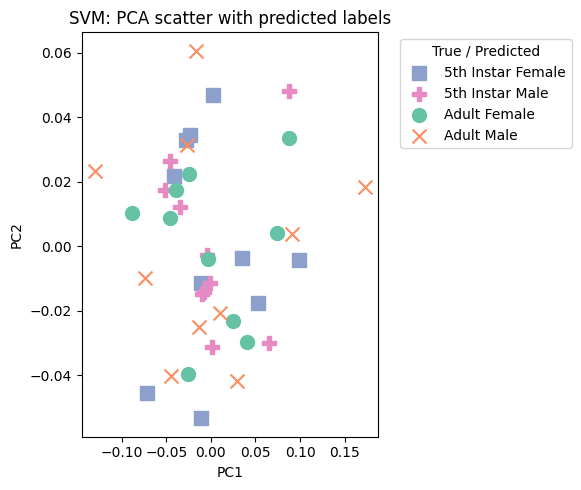

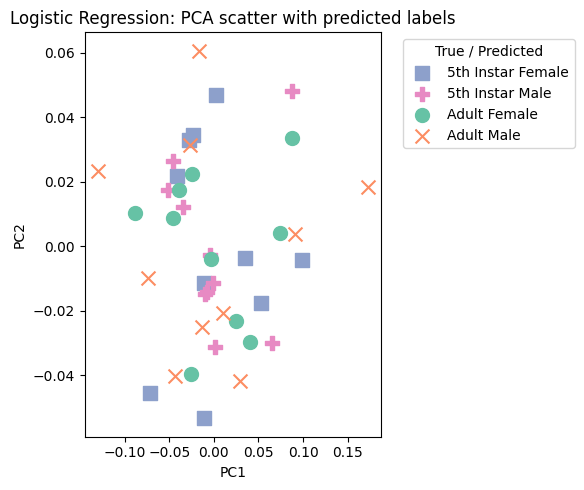

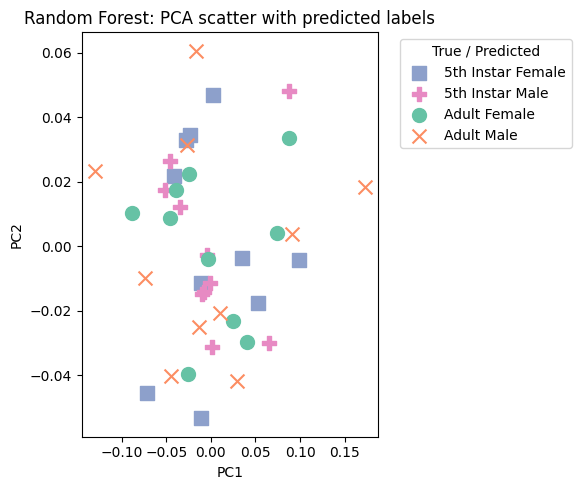

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Use first two PCs for visualization
X_vis = X[:, :2]
y_true_labels = le.inverse_transform(y_enc)

models_to_plot = ['SVM', 'Logistic Regression', 'Random Forest']

# --- FIXED styling to match your attached RF plot ---
class_styles = {
    "Adult Female": {"color": "#66c2a5", "marker": "o"},
    "Adult Male": {"color": "#fc8d62", "marker": "x"},
    "5th Instar Female": {"color": "#8da0cb", "marker": "s"},
    "5th Instar Male": {"color": "#e78ac3", "marker": "P"},
}

for name in models_to_plot:
    model = models[name]

    # Train on full data for plotting
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])
    pipeline.fit(X_vis, y_enc)
    y_pred_labels = le.inverse_transform(pipeline.predict(X_vis))

    # ---- Manual Matplotlib Plot (matches RF exactly) ----
    plt.figure(figsize=(6, 5))

    for cls in np.unique(y_true_labels):
        mask = y_true_labels == cls
        plt.scatter(
            X_vis[mask, 0],
            X_vis[mask, 1],
            s=100,
            c=class_styles[cls]["color"],
            marker=class_styles[cls]["marker"],
            label=cls
        )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{name}: PCA scatter with predicted labels")

    plt.legend(title="True / Predicted", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
